In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [2]:
# load datasets
df_train = pd.read_csv('data/census_income_learn.csv', header=None)
df_test = pd.read_csv('data/census_income_test.csv', header=None)

# view first 3 rows of training data
print(df_train.shape)
df_train.head(n=3)

(199523, 42)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


In [3]:
# load text file and extract column names: a bit messy, but does the job
with open('data/census_income_metadata.txt') as f:
    content = f.readlines()
    
names = []
for line in content[81:121]:
    name = line[line.find("(")+1:line.find(")")]
    names.append(name)

# add column name for income target and show a few names
names.append('income')
print(names[0:5])

['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education']


The meta data file indicates that instance weight feature should not be used for classifiers, so we need to drop this from both the training and testing datasets. We then attach the column names and view a few rows again. We then have a quick look at the distribution of the target variable.

In [4]:
# drop instance weight column
df_train = df_train.drop(df_train.columns[24], axis=1)
df_test = df_test.drop(df_test.columns[24], axis=1)

# add columns names
df_train.columns = names
df_test.columns = names

# look at shape and first few rows again
print(df_train.shape)
df_train.head(n=3)

(199523, 41)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


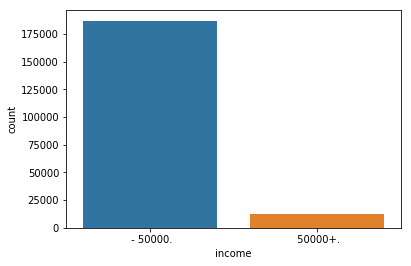

 - 50000.    187141
 50000+.      12382
Name: income, dtype: int64


In [5]:
# have a look at data distribution among targets
sns.countplot(df_train.income)
plt.show()
print(df_train.income.value_counts())

Seems that our target is highly skewed towards income below 50,000. Next step, what sort of data types do we have. Note, the metadata gives information on what the data types should be, so we need to convert types that have neen inferred by pandas incorrectly. These are typically features with numerical codes. 

In [6]:
# what are the data types like?
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
age                                           199523 non-null int64
class of worker                               199523 non-null object
detailed industry recode                      199523 non-null int64
detailed occupation recode                    199523 non-null int64
education                                     199523 non-null object
wage per hour                                 199523 non-null int64
enroll in edu inst last wk                    199523 non-null object
marital stat                                  199523 non-null object
major industry code                           199523 non-null object
major occupation code                         199523 non-null object
race                                          199523 non-null object
hispanic origin                               199523 non-null object
sex                                           199523 non-null obj

In [7]:
def type_change(df):
    # change data type of a few columns that are incorrect
    df['detailed industry recode'] = df['detailed industry recode'].astype(str)
    df['detailed occupation recode'] = df['detailed occupation recode'].astype(str)
    df['own business or self employed'] = df['own business or self employed'].astype(str)
    df['veterans benefits'] = df['veterans benefits'].astype(str)
    df['year'] = df['year'].astype(str)
    return df

In [8]:
df_train = type_change(df_train)
df_test = type_change(df_test)

As a large number of the features are nominal, lets have a look at the unique counts, we can get an idea of the number of levels, and the number of dummies we may end up creating.

In [9]:
pd.Series({col: len(pd.unique(df_train[col])) for col in df_train})

age                                             91
class of worker                                  9
detailed industry recode                        52
detailed occupation recode                      47
education                                       17
wage per hour                                 1240
enroll in edu inst last wk                       3
marital stat                                     7
major industry code                             24
major occupation code                           15
race                                             5
hispanic origin                                 10
sex                                              2
member of a labor union                          3
reason for unemployment                          6
full or part time employment stat                8
capital gains                                  132
capital losses                                 113
dividends from stocks                         1478
tax filer stat                 

Seems that most of the object features have a maximum of around 50 categories, of which many have considerably fewer. Although continuous capital gains and losses appear to have very few unique values, could be quite a few with no reported value or zero. Let's now also view the full record for a few rows.

In [10]:
df_train.iloc[0]

age                                                                                  73
class of worker                                                         Not in universe
detailed industry recode                                                              0
detailed occupation recode                                                            0
education                                                          High school graduate
wage per hour                                                                         0
enroll in edu inst last wk                                              Not in universe
marital stat                                                                    Widowed
major industry code                                         Not in universe or children
major occupation code                                                   Not in universe
race                                                                              White
hispanic origin                 

Seems like some of the features have ? as a resulting value, we can assume this data is missing. Lets check how much missing data we have. It also appears that all strings originally in the dataset have a random space infront of them, e.g. ' Not in universe', so we need to map ' ?' to NaN.

In [11]:
# replace question marks and count number of nulls
df_train.replace({' ?': np.nan}, inplace=True)
missing = df_train.isnull().sum()[df_train.isnull().sum() > 0].index # store names of features with missing values
df_train.isnull().sum()

age                                               0
class of worker                                   0
detailed industry recode                          0
detailed occupation recode                        0
education                                         0
wage per hour                                     0
enroll in edu inst last wk                        0
marital stat                                      0
major industry code                               0
major occupation code                             0
race                                              0
hispanic origin                                   0
sex                                               0
member of a labor union                           0
reason for unemployment                           0
full or part time employment stat                 0
capital gains                                     0
capital losses                                    0
dividends from stocks                             0
tax filer st

So of the approx 20,000 records nearly 50% are missing migration based features. Other than this information about country of birth and previous residence are missing values. This seems to be similar for the testing data also. Although we are missing state of previous address we do still have a less precise region of previous address. We should now have a look at some plots of the features with missing values.

In [12]:
def bars(var):
    plt.figure(figsize=(15,5))
    for i, name in enumerate(var):
        plt.subplot(121+i)
        ax = sns.countplot(x=name, hue='income', data=df_train)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7)
    plt.show()

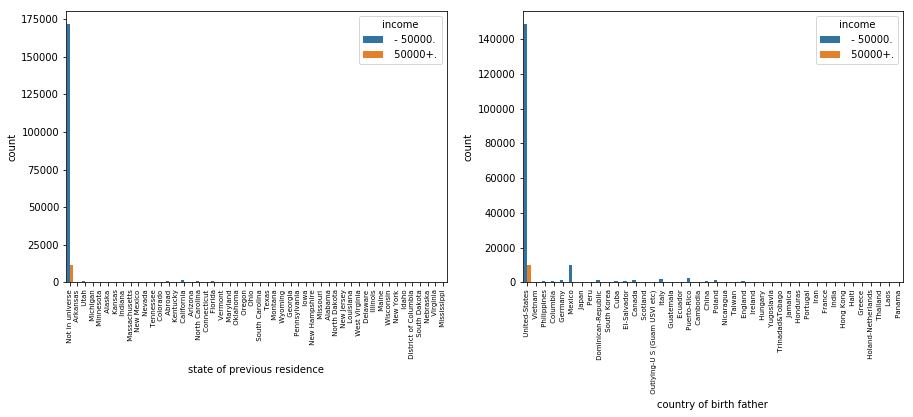

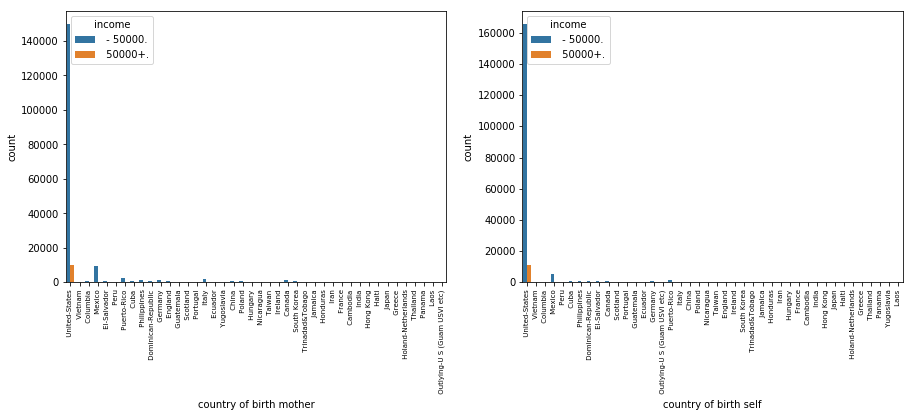

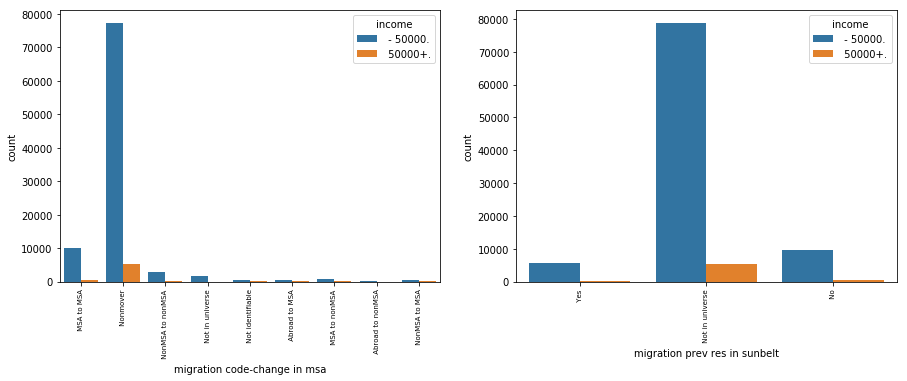

In [13]:
# lets have a look at the bar plots for some of the features we're missing data for
var = [['state of previous residence', 'country of birth father'], 
       ['country of birth mother', 'country of birth self'],
      ['migration code-change in msa', 'migration prev res in sunbelt']]

for va in var:
    bars(va)

The mode of each feature with missing data seems to be clearly defined, especially for the features with less than 10,000 missing records. Those with nearly half of the records missing are a little more problematic, but for now let's just fill in with the mode - we can always come back to this later. These features may not be to useful anyway as there doesn't appear to be any significant relationship with income, especially for those with mode 'not in universe'.

In [14]:
# fill NA's with mode of training dataset
for name in missing:
    df_train[name].fillna(value=df_train[name].mode().item(), inplace=True)
    df_test[name].fillna(value=df_train[name].mode().item(), inplace=True)

In [15]:
# quick check that we no longer have any null values
print("Number of training with null:", df_train.isnull().values.sum())
print("Number of testing with null:", df_test.isnull().values.sum())

Number of training with null: 0
Number of testing with null: 0


We should now have a quick look at some of the other categorical variables, again we create a few barplots.

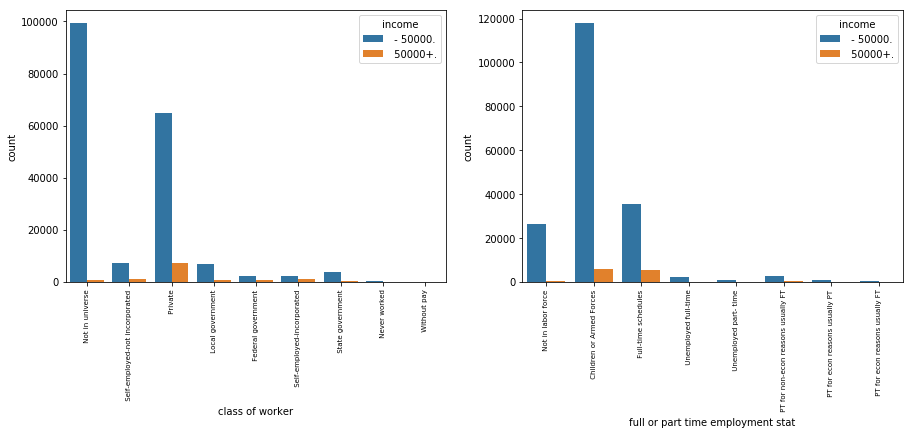

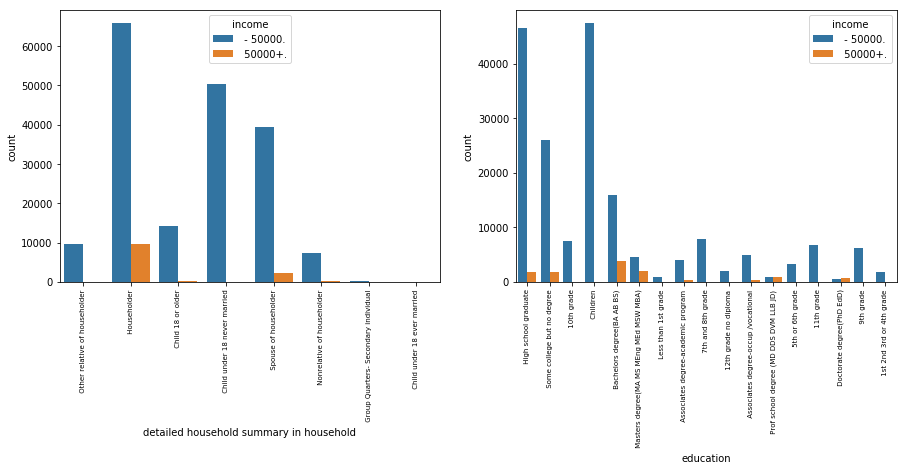

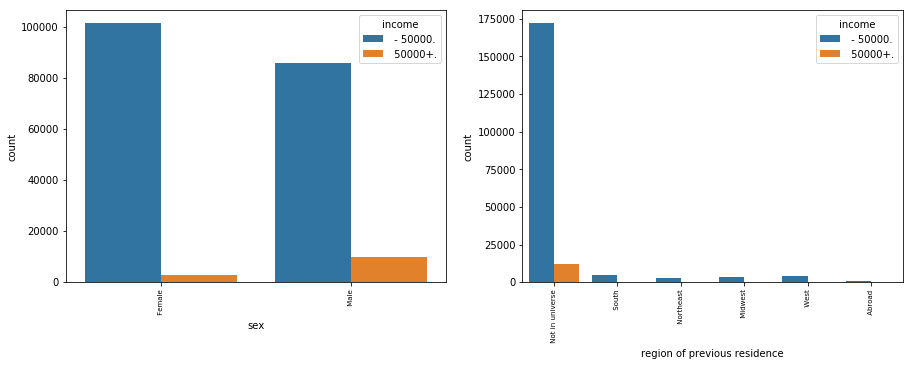

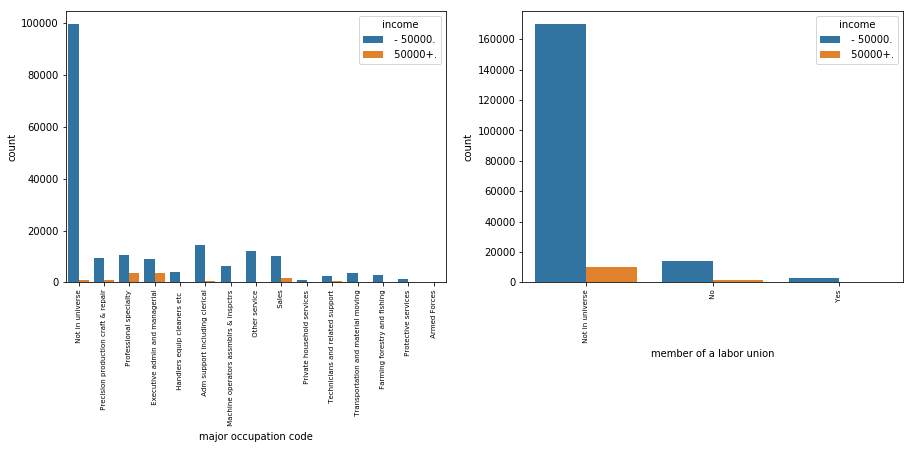

In [16]:
var = [['class of worker', 'full or part time employment stat'], ['detailed household summary in household', 'education'],
      ['sex', 'region of previous residence'], ['major occupation code', 'member of a labor union']]

for va in var:
    bars(va)

From the above plots we can see a few features that may give an indication of higher income. A higher proportion of those with +50,000 have 'detailed household summary in household' as householder, eduction level as bachelor's or masters and major occupation code of professional speciality or executive admin and managerial.

We now move onto the continuous data. First consider how many have value of zero, then we look at the correlations between the variables.

In [17]:
(df_train.select_dtypes(include=['int', 'float']) == 0).sum()

age                                  2839
wage per hour                      188219
capital gains                      192144
capital losses                     195617
dividends from stocks              178382
num persons worked for employer     95983
weeks worked in year                95983
dtype: int64

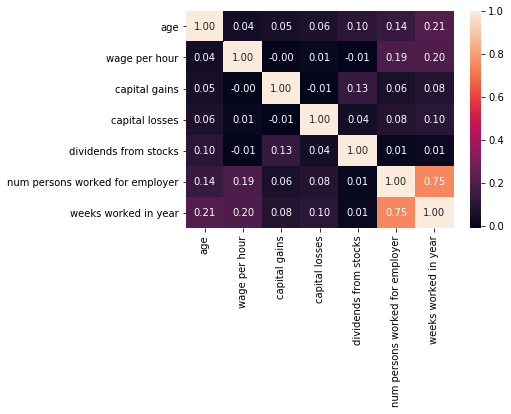

In [18]:
sns.heatmap(df_train.select_dtypes(include=['int', 'float']).corr(), annot=True, fmt = ".2f")
plt.show()

It seems that we have quite a few people with age of 0, maybe this is missing data, or maybe the census captures young people too, would have to look at the density plot for age to decide. Financial features seem to be mostly missing, could be genuine, but could also have not been reported. We can compare wage per hour with the number in employment, along with weeks worked in year to get an idea of this. 

Seems to be little correlation between the continuous variables, with the exception of num persons worked for employer and weeks worked in year. Lets now have a better look at the distribution of the continuous data.

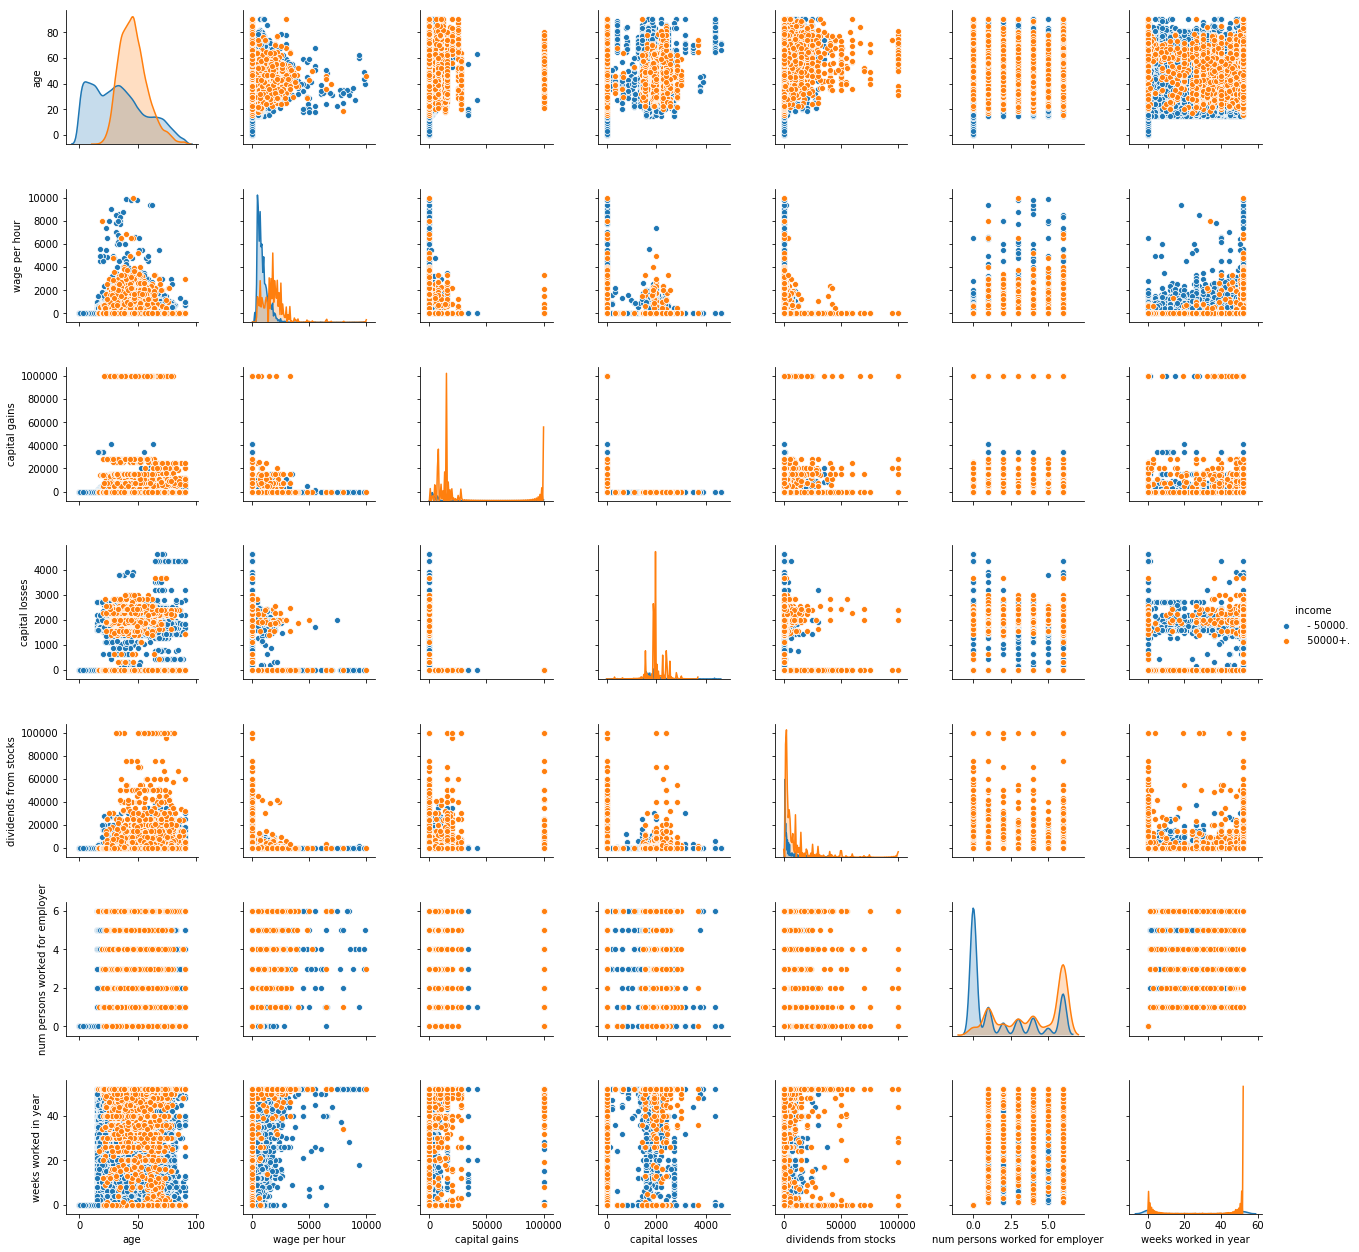

In [20]:
data = pd.concat([df_train['income'], df_train.select_dtypes(include=['int', 'float'])], axis=1)
sns.pairplot(data, diag_kind='kde', hue='income')
plt.show()

It would appear that age is a strong identifier for income, with the two density estimates looking quite dissimilar. Wage per hour and num persons worked for employer could also be good indicators for income.

In [23]:
df = df_train.select_dtypes(include=['int', 'float'])
df = (df - df.mean()) / (df.std()) # standardize

data = pd.concat([df_train['income'], df.iloc[:,0], df.iloc[:, 5:7]], axis=1)
data = pd.melt(data, id_vars='income',
                     var_name="features",
                     value_name='value')

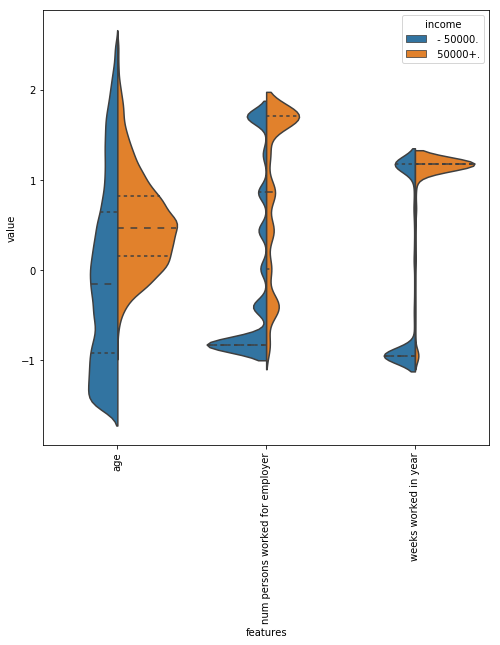

In [24]:
plt.figure(figsize=(8,8))
sns.violinplot(x="features", y="value", hue="income", data=data, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

The violin confirms that age, num persons worked and weeks worked in year appear to have differences between those with higher and lower income. We ignore wage per hour here as a few extreme values distort the plot even when standardizing.

Finally, we need to convert the categorical variables into dummies that we can pass into a learning algorithm. In doing so we drop the first column of each set of dummies, we then have a few columns to drop and add to the testing dataset to ensure it is the same as the training set.

In [25]:
# convert object columns to dummy variables
train = pd.get_dummies(df_train, columns=df_train.select_dtypes(include=['object']).columns, drop_first=True)
test = pd.get_dummies(df_test, columns=df_train.select_dtypes(include=['object']).columns, drop_first=True)

print('Training Dataset:', train.shape)
print('Testing Dataset:', test.shape)

Training Dataset: (199523, 470)
Testing Dataset: (99762, 477)


In [26]:
# add in columns missing from testing dataset
to_add = np.setdiff1d(train.columns, test.columns)
test = test.assign(**{c: 0 for c in to_add})
print("Adding in:", to_add)

# drop columns in test not in train
to_drop = np.setdiff1d(test.columns, train.columns)
test.drop(to_drop, axis=1, inplace=True)
print("Dropping columns:", to_drop)

# reorder testing set so it matches training set
test = test[train.columns]

print()
print('Training Dataset:', train.shape)
print('Testing Dataset:', test.shape)

Adding in: [ 'detailed household and family stat_ Grandchild <18 ever marr not in subfamily']
Dropping columns: ['country of birth father_ Cambodia' 'country of birth mother_ Cambodia'
 'country of birth self_ Cambodia'
 'migration code-change in msa_ Abroad to MSA'
 'migration code-change in reg_ Abroad'
 'migration code-move within reg_ Abroad'
 'migration prev res in sunbelt_ No' 'state of previous residence_ Abroad']

Training Dataset: (199523, 470)
Testing Dataset: (99762, 470)


### Model Fitting

In [72]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [60]:
# extract training data and labels
X = train.iloc[:, 0:-1]
Y = train['income_ 50000+.']

# extract testing data and labels
X_test = test.iloc[:, 0:-1]
Y_test = test['income_ 50000+.']

In [62]:
# just for reference, if we predicted zero everytime what would our accuracy be.
print('Predict less than 50,000 every time:', np.sum(np.zeros_like(Y_test) == Y_test)/(len(Y_test)))

Predict less than 50,000 every time: 0.937992421964


In [116]:
# train logistic regression model with L1 loss
model = LR(penalty='l1', random_state=4)
model.fit(X, Y)

# print accuracy
print("Testing Accuracy:", model.score(X_test, Y_test))

Testing Accuracy: 0.953489304545


In [117]:
pred = model.predict(X_test)
confusion_matrix(Y_test, pred, labels=None, sample_weight=None)

array([[92696,   880],
       [ 3760,  2426]])

We seem to have quite a few type II errors, we predicted that 3760 records did not have greater than 50,000 when they did. It seems that when income is above 50,000 we are able to identify it less than 40% of the time (recall), while we are correct 73% of the time when we predict that income is above 50,000 (precision).

In [111]:
# create random forest model and train
model = RandomForestClassifier(n_estimators=50, random_state=4)
model.fit(X, Y)

# print accuracy
print("Testing Accuracy:", model.score(X_test, Y_test))

Testing Accuracy: 0.953088350274


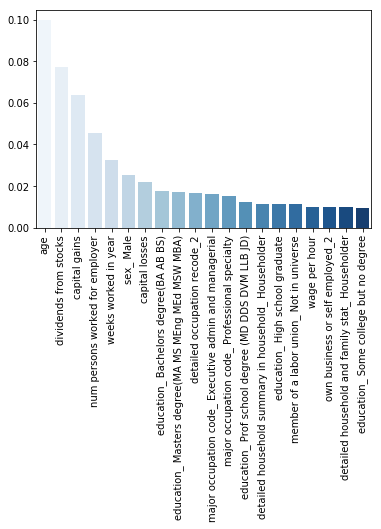

In [108]:
# extract feature importance information
feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['importance']
                                  ).sort_values('importance', ascending=False)

# plot feature importance
sns.barplot(x=feature_importances.index[0:20], y=feature_importances.importance.values[0:20], palette="Blues")
plt.xticks(rotation=90)
plt.show()

The Random Forest model performed similarly to logistic regression. The above feature importance values show that age and financial information such as dividends and capital gains were important for classification. Both number of persons worked for employer and weeks worked in the year were also important, although these two variables are quite correlated. 

Further work:
- Hyperparameter tuning, especially for the random forest.
- Could look at feature engineering, especially with financial variables as these seem quite significant.
- Investigate different models, such as support vector classifier or boosting algorithms.